In [1]:
import numpy as np
import os
import soundfile as sf
from sklearn.manifold import Isomap
import pickle
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")
import features
import pandas as pd
import librosa
import ftm_ver2
import IPython.display as ipd
from kymatio.torch import TimeFrequencyScattering1D,Scattering1D
import torch
import copy
from sklearn.preprocessing import MinMaxScaler,StandardScaler
sys.path.append("/home/han/kymatio-jtfs/")
from kymatio.scattering1d.core import timefrequency_scattering1d as tf_scat
from sklearn.neighbors import NearestNeighbors

In [3]:
import tensorflow as tf
sample_weight = np.array([1,2,3,4,5])
sample_weight = tf.squeeze(sample_weight, [-1])

2022-06-19 10:00:57.923511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 10:00:57.924203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 10:00:57.931187: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 10:00:57.931863: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 10:00:57.932508: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

InvalidArgumentError: Can not squeeze dim[0], expected a dimension of 1, got 5 [Op:Squeeze]

In [5]:
sample_weight = np.array([1,2,3,4,5])[:,None]
print(sample_weight.shape)
sample_weight = tf.squeeze(sample_weight, [-1])

(5, 1)


## goal:
1. compute JTFS for all sounds in training sete
2. make nearest neighbor graph of these features
3. compute average neighbor distance per parameter per example
4. save into a numpy file

In [2]:
feature_path = "/home/han/data/drum_data/han2022features-pkl/"
audio_path = "/home/han/data/drum_data/"

In [3]:
sr = 22050
N = 2**16
J = 13
Q = 16
T = 2**11
fold_str = "train"

In [4]:
csv_path =  fold_str + "_param_v2.csv"
df = pd.read_csv(csv_path)
sample_ids = df.values[:, 0]
y = df.values[:,1:-1]
#check range of parameters of the first 500 examples, make sure it's randomized enough

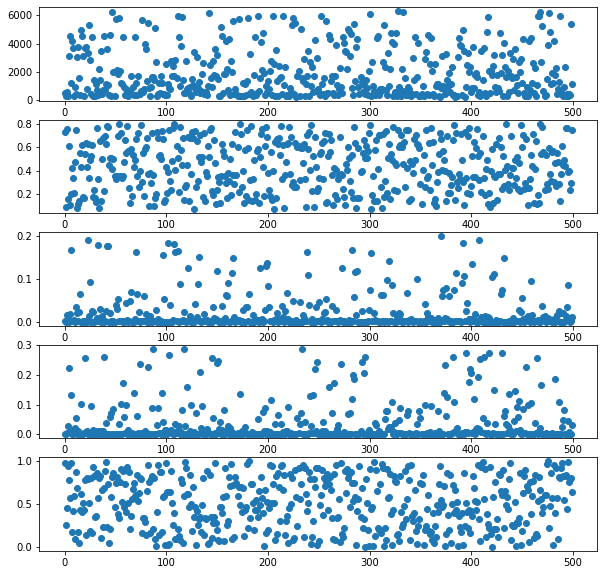

In [5]:
plt.subplots(5,1,figsize=(10,10))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.scatter(np.arange(0,500,1),y[100:600,i])

In [76]:
# For a new value newValue, compute the new count, new mean, the new M2.
# mean accumulates the mean of the entire dataset
# M2 aggregates the squared distance from the mean
# count aggregates the number of samples seen so far
def update(existingAggregate, newValue):
    (count, mean, M2) = existingAggregate
    count += 1
    delta = newValue - mean
    mean += delta / count
    delta2 = newValue - mean
    M2 += delta * delta2
    return (count, mean, M2)

# Retrieve the mean, variance and sample variance from an aggregate
def finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    if count < 2:
        return float("nan")
    else:
        (mean, variance, sampleVariance) = (mean, M2 / count, M2 / (count - 1))
        return (mean, variance, sampleVariance)
    
def welford(feature_path,log_scale):
    """
    compute running variance of a collection of feature vectors
    """
    count = 1
    feat_files = os.listdir(feature_path)
    mean = np.load(os.path.join(feature_path,feat_files[0])).squeeze()
    if log_scale:
        mean = np.log1p(((mean>0)*mean)/log_scale)
    var = np.zeros(mean.shape)
    existingAggregate = (count, mean, var)
    for i in range(1,len(feat_files)):
        if i% 100 == 0:
            print(i)
        newValue = np.load(os.path.join(feature_path,feat_files[i])).squeeze()
        if log_scale:
            newValue = np.log1p(((newValue>0)*newValue)/log_scale)
        existingAggregate = update(existingAggregate, newValue)
        mean_running,variance_running, sampvar_running = finalize(existingAggregate)
    return mean_running, variance_running, sampvar_running

In [78]:
mean_train_log, var_train_log, sampvar_train_log = welford(feature_path,log_scale=1e-5)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [26]:
feature_path = "/home/han/data/drum_data/han2022features-pkl/jtfs_j14_q16/test"
mean_train, var_train, sampvar_train = welford(feature_path)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [79]:
np.sum(sampvar_train_log<1e-7),np.sum(sampvar_train_log>=1e-7)

(0, 34464)

Text(0, 0.5, 'log variance of the feature')

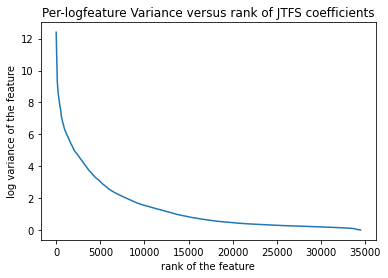

In [83]:
#plot running log(variance) as a function of rank
plt.plot(np.arange(1,sampvar_train_log.shape[0]+1),np.flip(np.sort(sampvar_train_log)))
#plt.xlim([0,2000])
plt.title("Per-logfeature Variance versus rank of JTFS coefficients")
plt.xlabel("rank of the feature")
plt.ylabel("log variance of the feature")

In [36]:
np.sum(sampvar_train<1e-7),np.sum(sampvar_train>=1e-7)

(17441, 17023)

Text(0, 0.5, 'log variance of the feature')

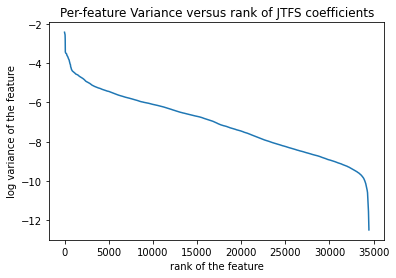

In [42]:
#plot running log(variance) as a function of rank
plt.plot(np.arange(1,sampvar_train.shape[0]+1),np.flip(np.sort(np.log10(sampvar_train))))
#plt.xlim([0,2000])
plt.title("Per-feature Variance versus rank of JTFS coefficients")
plt.xlabel("rank of the feature")
plt.ylabel("log variance of the feature")

In [9]:
# load mean neighbor distance
test_dist = np.load(os.path.join(audio_path,"test_nbr_dist.npy"))

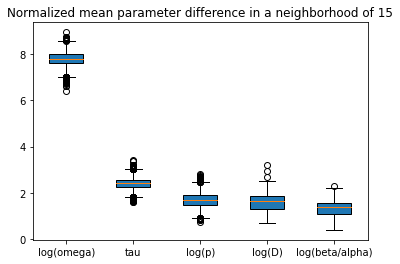

In [23]:
#applying log directly when calculating normalized difference
labels = ['log(omega)','tau','log(p)','log(D)','log(beta/alpha)']
bp0 = plt.boxplot(np.log1p(1/test_dist[:,[0,1,2,3,4]]), labels=labels, patch_artist=True)

for box in bp0['boxes']:
    # change outline color
    #box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'C0' )
    # change hatch
    #box.set(hatch = '/')

#log w, p, D, beta/alpha
plt.title('Normalized mean parameter difference in a neighborhood of 15')

plt.show()

In [73]:
def load_jtfs(feature_path,fold_str):
    csv_path = "../notebooks/" + fold_str + "_param_v2.csv"
    df = pd.read_csv(csv_path)
    sample_ids = df.values[:, 0]
    y = df.values[:,1:-1]
    ba = 1/y[:,-1] + 1/y[:,-1]**2
    y_ba = np.hstack((y, ba[:,None]))
    
    jtfs_set = []
    num = 0
    for i in sample_ids:
        wav_path = os.path.join(feature_path,"jtfs_j"+str(J)+"_q"+str(Q),fold_str,
                                       fold_str+"_"+str(i)+".npy")
        if os.path.exists(wav_path):
            jtfs_wav = np.load(wav_path)
            jtfs_set.append(jtfs_wav)
            num += 1
        if num % 100 == 0:
            print(num)
    jtfs_set = np.stack(jtfs_set)
    jtfs_set = np.maximum(0,jtfs_set.reshape((jtfs_set.shape[0],
                            jtfs_set.shape[1]*jtfs_set.shape[2]*jtfs_set.shape[3])))
    return jtfs_set,y_ba


#load jtfs coeff
J = 14
feat_path = "/home/han/data/drum_data/han2022features-pkl/"
test_jtfs, y_test = load_jtfs(feat_path,"test")
test_jtfs.shape

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


(10000, 34464)

In [60]:
k = 1000
idx = np.flip(np.argsort(sampvar_train))[:k]
reduced_test_jtfs = test_jtfs[:,idx]

In [65]:
#perform nearest neighbor
n_nbr = 40
nbrs = NearestNeighbors(n_neighbors=n_nbr, algorithm='ball_tree').fit(reduced_test_jtfs)
distances, indices = nbrs.kneighbors(reduced_test_jtfs)

In [74]:
param_dist = compute_mean_dist(indices,n=15,y=y_test)
param_dist.shape

(10000, 6)

In [70]:
def compute_mean_dist(indices,n,y):   
    """
    n: number of neighbors to average from
    y: ground truth parameters
    """
    # calculate the mean parameter distance from n neighbors for each example
    param_dist = []
    for i in range(indices.shape[0]):
        param_current = y[i,:].astype(np.float64)
        #get the parameters of these neighbors 
        param_nbrs = copy.deepcopy(y[indices[i,:n],:]).astype(np.float64)
        #logscale p and D and ba
        param_nbrs[:,[0,2,3,5]] = np.log10(param_nbrs[:,[0,2,3,5]])
        param_current[[0,2,3,5]] = np.log10(param_current[[0,2,3,5]])
        param_dist.append(np.mean(np.abs(param_nbrs-param_current),axis=0)/np.abs(param_current))

    param_dist = np.stack(param_dist)
    return param_dist

In [45]:
#initialize jtfs
jtfs = TimeFrequencyScattering1D(
                J = J, #scale
                shape = (N, ), 
                Q = Q, #filters per octave, frequency resolution
                T = T, 
                max_pad_factor=1,
                max_pad_factor_fr=1,
                average_fr = False,
            ).cuda()

In [37]:

x = np.random.random(N)
print(x)

[0.70735152 0.56125041 0.67174661 ... 0.70760301 0.05559632 0.88394552]


In [43]:
jtfs_glo = TimeFrequencyScattering1D(
                J = J, #scale
                shape = (N, ), 
                Q = Q, #filters per octave, frequency resolution
                T = N,
                average = True,
                max_pad_factor=1,
                max_pad_factor_fr=1,
                average_fr = False,
            ).cuda()

In [46]:
sx1 = jtfs(torch.tensor(x))
sx2 = jtfs_glo(torch.tensor(x))

In [48]:
sx1.shape,sx2.shape

(torch.Size([1, 28987, 32]), torch.Size([1, 28987, 1]))

In [12]:
#computee all of jtfs coefficients
#train_jtfs, y_train = make_jtfs(jtfs,"train")

In [14]:
#loading the saved jtfs features
train_jtfs_loaded,y_train_loaded = load_jtfs("train")

In [23]:
#nearest neighbor
#isomap
n_components = 3
n_neighbors = 40

train_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
Y_train = train_isomap.fit_transform(train_jtfs.cpu()) #compute knn graph, apply dimensionality reducton


In [26]:
n = 20
ba_train = 1/y_train[:,-1] + 1/y_train[:,-1]**2
y_train_ba = np.hstack((y_train,ba_train[:,None]))
train_dist = compute_mean_dist(train_isomap,n,y_train_ba)

In [28]:
#mean normalized neighbor difference
max_weights = []
nbrs = [5,10,15,20,40]
for n in nbrs:
    train_dist = compute_mean_dist(train_isomap,n,y_train_ba)
    weights = 1/train_dist
    max_weights.append(np.max(weights,axis=0)/np.sum(np.max(weights,axis=0))) #normalize per row
max_weights = np.stack(max_weights) #(diff neighrbos, max weights)
pd.DataFrame(np.hstack((np.array(nbrs)[:,None],max_weights)),
             columns=["nbrs","omega","tau","p","D","alpha","beta/alpha"],
            )

,nbrs,omega,tau,p,D,alpha,beta/alpha
0,5.0,0.971626,0.010761,0.003148,0.005860,0.003954,0.004650
1,10.0,0.973676,0.008166,0.004945,0.005185,0.003940,0.004089
2,15.0,0.972503,0.008276,0.005702,0.005806,0.004125,0.003588
3,20.0,0.968102,0.008171,0.006412,0.006934,0.005590,0.004791
4,40.0,0.929095,0.017393,0.015902,0.014365,0.012639,0.010606


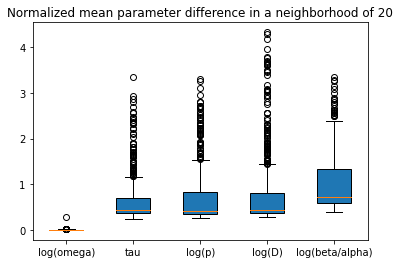

In [33]:
#applying log directly when calculating normalized difference
labels = ['log(omega)','tau','log(p)','log(D)','log(beta/alpha)']
bp0 = plt.boxplot(train_dist[:,[0,1,2,3,5]], labels=labels, patch_artist=True)

for box in bp0['boxes']:
    # change outline color
    #box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'C0' )
    # change hatch
    #box.set(hatch = '/')

#log w, p, D, beta/alpha
plt.title('Normalized mean parameter difference in a neighborhood of 20')

plt.show()

## derive mean difference from normalized parameters
1. normalize the ground truth between 0 and 1 
2. make box plot

In [40]:
def preprocess_gt(y_train):
    #logscale
    y_train_log = copy.deepcopy(y_train)
    y_train_log[:,[0,2,3,5]] = np.log10(y_train[:,[0,2,3,5]].astype(np.float64))
    #normalize
    scaler = MinMaxScaler()
    scaler.fit(y_train_log)
    y_train_normalized = scaler.transform(y_train_log)

    return y_train_normalized
def compute_mean_dist_norm(isomap,n,y):#targeting already normalized ground truth
    # calculate the mean parameter distance from n neighbors for each example
    param_dist = []
    for i in range(isomap.dist_matrix_.shape[0]):
        param_current = y[i,:].astype(np.float64)
        nbrs = np.argsort(isomap.dist_matrix_[i,:])[1:n+1]
        #get the parameters of these neighbors 
        param_nbrs = copy.deepcopy(y[nbrs,:]).astype(np.float64)
        #logscale p and D and ba
        param_dist.append(np.mean(np.abs(param_nbrs-param_current),axis=0))#/np.abs(param_current))

    param_dist = np.stack(param_dist)
    return param_dist

In [41]:
y_train_ba_norm = preprocess_gt(y_train_ba)
train_dist_norm = compute_mean_dist_norm(train_isomap,n,y_train_ba_norm)

In [42]:
#mean normalized neighbor difference
max_weights = []
nbrs = [5,10,15,20,40]
for n in nbrs:
    train_dist_norm = compute_mean_dist_norm(train_isomap,n,y_train_ba_norm)
    weights = 1/train_dist_norm
    max_weights.append(np.max(weights,axis=0)/np.sum(np.max(weights,axis=0))) #normalize per row
max_weights = np.stack(max_weights) #(diff neighrbos, max weights)

In [43]:
#maximum weights
pd.DataFrame(np.hstack((np.array(nbrs)[:,None],max_weights)),
             columns=["nbrs","omega","tau","p","D","alpha","beta/alpha"],
            )

,nbrs,omega,tau,p,D,alpha,beta/alpha
0,5.0,0.783467,0.040480,0.016223,0.021991,0.016361,0.121477
1,10.0,0.818196,0.036766,0.015249,0.016185,0.015199,0.098405
2,15.0,0.821541,0.031913,0.017450,0.017223,0.014553,0.097320
3,20.0,0.791878,0.030251,0.018948,0.018975,0.018760,0.121188
4,40.0,0.632762,0.052300,0.036939,0.036749,0.037358,0.203892


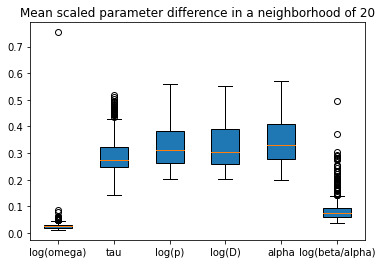

In [46]:
#applying log directly when calculating normalized difference
labels = ['log(omega)','tau','log(p)','log(D)','alpha','log(beta/alpha)']
bp0 = plt.boxplot(train_dist_norm[:,[0,1,2,3,4,5]], labels=labels, patch_artist=True)

for box in bp0['boxes']:
    # change outline color
    #box.set(color='black', linewidth=2)
    # change fill color
    box.set(facecolor = 'C0' )
    # change hatch
    #box.set(hatch = '/')


plt.title('Mean scaled parameter difference in a neighborhood of 20')

plt.show()

In [55]:
def make_jtfs(jtfs,fold_str):
    csv_path =  fold_str + "_param_v2.csv"
    df = pd.read_csv(csv_path)
    sample_ids = df.values[:, 0]
    y = df.values[:,1:-1]
    jtfs_set = []
    #load sound files
    num = 0
    #os.makedirs(os.path.join(feature_path,"jtfs_j8_q16_t11"),exist_ok=True)
    for i in sample_ids:
        filename = "_".join([str(i),"sound.wav"])
        file_path = os.path.join(audio_path,fold_str,filename)
        wav, sr = sf.read(file_path)
        jtfs_wav = jtfs(wav)/np.linalg.norm(wav,ord=2)
        #if not os.path.exists(os.path.join(feature_path,"jtfs_j8_q16_t11",fold_str+"_"+str(i)+".npy")):
        np.save(os.path.join(feature_path,"jtfs_j8_q16_t11",fold_str+"_"+str(i)+".npy"),jtfs_wav.cpu())
        jtfs_set.append(jtfs_wav.cpu().numpy())
        num += 1
        if num > 500:
            break
    jtfs_set = np.stack(jtfs_set)
    jtfs_set = np.maximum(torch.tensor(0),
                             jtfs_set.reshape((jtfs_set.shape[0],
                            jtfs_set.shape[1]*jtfs_set.shape[2]*jtfs_set.shape[3])))
    return jtfs_set,y

def load_jtfs(feature_path,fold_str):
    csv_path = "../notebooks/" + fold_str + "_param_v2.csv"
    df = pd.read_csv(csv_path)
    sample_ids = df.values[:, 0]
    y = df.values[:,1:-1]
    ba = 1/y[:,-1] + 1/y[:,-1]**2
    y_ba = np.hstack((y, ba[:,None]))
    
    jtfs_set = []
    num = 0
    for i in sample_ids:
        if os.path.exists(os.path.join(feature_path,"jtfs_j"+str(J)+"_q"+str(Q),fold_str,
                                       fold_str+"_"+str(i)+".npy")):
            jtfs_wav = np.load(os.path.join(feature_path,"jtfs_j"+str(J)+"_q"+str(Q),fold_str,
                                            fold_str+"_"+str(i)+".npy"))
            jtfs_set.append(jtfs_wav)
            num += 1
        if num % 100 == 0:
            print(num)
    jtfs_set = np.stack(jtfs_set)
    jtfs_set = np.maximum(0,jtfs_set.reshape((jtfs_set.shape[0],
                            jtfs_set.shape[1]*jtfs_set.shape[2]*jtfs_set.shape[3])))
    return jtfs_set,y
def compute_mean_dist(isomap,n,y):        
    # calculate the mean parameter distance from n neighbors for each example
    param_dist = []
    for i in range(isomap.dist_matrix_.shape[0]):
        param_current = y[i,:].astype(np.float64)
        nbrs = np.argsort(isomap.dist_matrix_[i,:])[1:n+1]
        #get the parameters of these neighbors 
        param_nbrs = copy.deepcopy(y[nbrs,:]).astype(np.float64)
        #logscale p and D and ba
        param_nbrs[:,[0,2,3,5]] = np.log10(param_nbrs[:,[0,2,3,5]])
        param_current[[0,2,3,5]] = np.log10(param_current[[0,2,3,5]])
        param_dist.append(np.mean(np.abs(param_nbrs-param_current),axis=0)/np.abs(param_current))

    param_dist = np.stack(param_dist)
    return param_dist